In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.rcParams['figure.figsize']=(10,18)
%matplotlib inline

# from datetime import datetime
# from datetime import date
import datetime as dt
from geopy.distance import great_circle
import xgboost as xgb
from sklearn.cluster import MiniBatchKMeans

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import sklearn
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Table of Contents

* [Loading & Exploring Dataset](#load)
* [Feature Engineering](#feature)
* [Exploratory Data Analysis (EDA)](#eda)
    * [Univariate Analysis](#eda_uni)
        * [trip_duration](#uni_trip_duration)
        * [vendor_id, passenger_count](#uni_vendor_id)
        * [store_and_fwd_flag, time_of_day](#uni_store)
        * [pickup_day_name, is_weekend](#uni_pickup1)
        * [pickup_day, pickup_month](#uni_pickup2)
        * [pickup_hour, pickup_minute](#uni_pickup3)
        * [trip_distance](#uni_distance)
    * [Bivariate Analysis](#eda_bi)
* [Simple ML Models](#mlmodel)
    * [Linear Regression](#ml_lr)
    * [Polynomial Linear](#ml_polylin)
    * [Polynomial Lasso](#ml_polylas)
    * [Polynomial Ridge](#ml_polyr)
    * [Polynomial ElasticNet](#ml_polyen)
    * [Decision Tree](#ml_dt)
    * [XGBoost](#ml_xgb)
    * [Multilayer Perceptron](#ml_mlp)
    * [Evaluation Scores](#ml_eval)
* [Hyperparameter Tuning](#hyper)
* [What went wrong?](#wrong)
* [Final Model](#final)

# Loading & Exploring Dataset <a class="anchor" id="load"></a>

In [ ]:
# Loading all dataset
train = pd.read_csv('dataset/train.csv', parse_dates=['pickup_datetime', 'dropoff_datetime'])
test = pd.read_csv('dataset/test.csv', parse_dates=['pickup_datetime'])

In [ ]:
train.info()

In [ ]:
train.describe()

#### Observation
- 2 unique vendor ids
- there's a 0 passenger count? - error?
- trip_duration for 1 sec - error again?

In [ ]:
test.info()

In [ ]:
test.describe()

In [ ]:
# Check for duplicate rows
print("Train set duplicates:", train.duplicated().sum())
print("Test set duplicates:", test.duplicated().sum())

In [ ]:
# Check for missing values
print("Train set missing values:\n{}".format(train.isnull().sum()))
print("\nTest set missing values:\n{}".format(test.isnull().sum()))

In [ ]:
# Check for data shape
print("Train set shape:", train.shape)
print("Test set shape:", test.shape)

Train dataset has 2 extra columns - dropoff_datetime, trip_duration

In [ ]:
train.hist(figsize=(20,20))
plt.show()

In [ ]:
train.nunique()

In [ ]:
# Dropping columns in train set - dropoff_datetime is used to calculate the target feature
train_cleaned = train.drop(['id','dropoff_datetime'], axis=1)
test_cleaned = test.drop(['id'], axis=1)

In [ ]:
test_cleaned.head()

# Feature Engineering <a class="anchor" id="feature"></a>

In [ ]:
# Extract more time features -> day, month, hour, minutes
def get_pickup_time(df):
    # day
    df['pickup_day_name'] = df['pickup_datetime'].dt.day_name()
    df['pickup_day_no'] = df['pickup_datetime'].dt.weekday # Monday=0, Sunday=6
    df['pickup_day'] = df['pickup_datetime'].dt.day
    # month
    df['pickup_month'] = df['pickup_datetime'].dt.month
    # hour
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    # minutes
    df['pickup_minute'] = df['pickup_datetime'].dt.minute
    
get_pickup_time(train_cleaned)
get_pickup_time(test_cleaned)

In [ ]:
# Add a is_weekend column
def is_weekend(x):
    if x == 'Saturday' or x == 'Sunday':
        return 1
    else:
        return 0

train_cleaned['is_weekend'] = train_cleaned['pickup_day_name'].apply(is_weekend)
test_cleaned['is_weekend'] = test_cleaned['pickup_day_name'].apply(is_weekend)

In [ ]:
# Get time of day -> morning, afternoon, evening, late (night/morning)
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late'
    
train_cleaned['time_of_day'] = train_cleaned['pickup_hour'].apply(time_of_day)
test_cleaned['time_of_day'] = test_cleaned['pickup_hour'].apply(time_of_day)

In [ ]:
holiday = pd.read_csv('dataset/NYC_2016Holidays.csv', sep=';')
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')
holiday_dates = [dt.datetime.strptime(holiday.loc[i,'Date'], '%B %d %Y').date() for i in range(len(holiday))]

In [ ]:
# Check if it is a holiday or close to holiday
def is_holiday(x):
    x = dt.datetime.date(x)
    for h in holiday_dates:
        if x == h:
            return 'Yes'
        elif (x-h).days == abs(1):
            return 'Close'
        else:
            return 'No'
    
train_cleaned['holiday'] = train_cleaned['pickup_datetime'].apply(is_holiday)
test_cleaned['holiday'] = test_cleaned['pickup_datetime'].apply(is_holiday)

In [ ]:
# Get trip distance with geopy great circle in km
def get_trip_distance(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    start = (pickup_lat, pickup_long)
    stop = (dropoff_lat, dropoff_long)
    return great_circle(start,stop).km

train_cleaned['trip_distance'] = train_cleaned.apply(lambda x: get_trip_distance(x['pickup_latitude'], x['pickup_longitude'], \
                                                                                 x['dropoff_latitude'], x['dropoff_longitude'] ), axis=1)
test_cleaned['trip_distance'] = test_cleaned.apply(lambda x: get_trip_distance(x['pickup_latitude'], x['pickup_longitude'], \
                                                                                 x['dropoff_latitude'], x['dropoff_longitude'] ), axis=1)

In [ ]:
# Get weather at the time
weather = pd.read_csv('dataset/KNYC_Metars.csv', parse_dates=['Time'])
weather['year'] = weather['Time'].dt.year
weather['pickup_month'] = weather['Time'].dt.month
weather['pickup_day'] = weather['Time'].dt.day
weather['pickup_hour'] = weather['Time'].dt.hour
weather = weather[weather['year'] == 2016][['pickup_month','pickup_day','pickup_hour','Events']]

In [ ]:
weather.head()

In [ ]:
trainf = pd.merge(train_cleaned, weather, on = ['pickup_month', 'pickup_day', 'pickup_hour'], how = 'left')
testf = pd.merge(test_cleaned, weather, on = ['pickup_month', 'pickup_day', 'pickup_hour'], how = 'left')

In [ ]:
trainf.Events.value_counts()

In [ ]:
sns.countplot(trainf.Events)

In [ ]:
trainf = trainf.astype({"Events": 'string'})
trainf.Events = trainf.Events.replace(['Rain', 'Snow', 'Fog', 'Fog\n\t,\nSnow'], 'Yes')
trainf.Events = trainf.Events.replace(['None'], 'No')
testf = testf.astype({"Events": 'string'})
testf.Events = testf.Events.replace(['Rain', 'Snow', 'Fog', 'Fog\n\t,\nSnow'], 'Yes')
testf.Events = testf.Events.replace(['None'], 'No')

In [ ]:
sns.countplot(trainf.Events)

In [ ]:
trainf.Events = trainf.Events.fillna('No')
testf.Events = testf.Events.fillna('No')

Converted all the eventful weather to 'Yes' to avoid sparse vector

In [ ]:
# trainf['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
# trainf.head()

In [ ]:
# Check for data shape
print("Train set shape:", trainf.shape)
print("Test set shape:", testf.shape)

In [ ]:
trainf.head()

As RMSLE is not sensitive to outliers, I did not remove any outliers in the dataset.

# Exploratory Data Analysis (EDA) <a class="anchor" id="eda"></a>

#### Assumptions made:
- The distribution for pickup_datetime and dropoff_datetime are similar, so we dropped dropoff_datetime from eda
- The weather condition for both pickup and dropoff are similar
- Outliers are not removed as RMSLE is robust to outliers

## Univariate Analysis <a class="anchor" id="eda_uni"></a>

### trip_duration <a class="anchor" id="uni_trip_duration"></a>

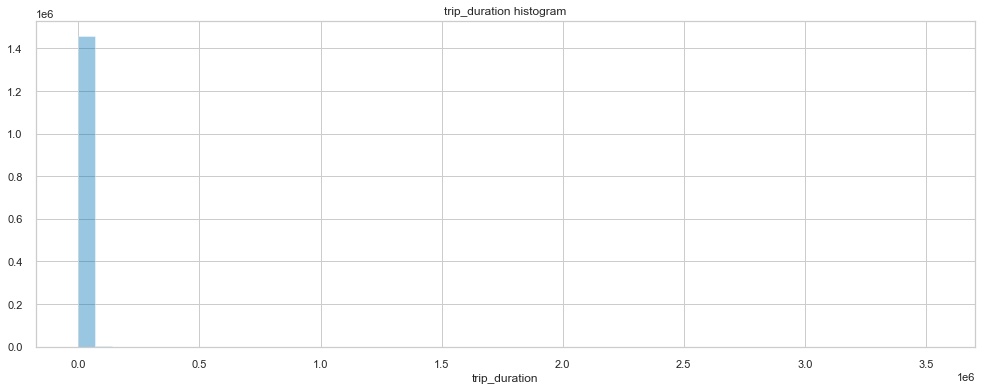

In [94]:
# Target feature
plt.figure(figsize=(15,6))
plt.style.use('seaborn-colorblind')
sns.distplot(trainf.trip_duration, kde=False)
plt.title("trip_duration histogram")
plt.savefig("images/trip_duration histogram.png", bbox_inches ="tight")
plt.show()

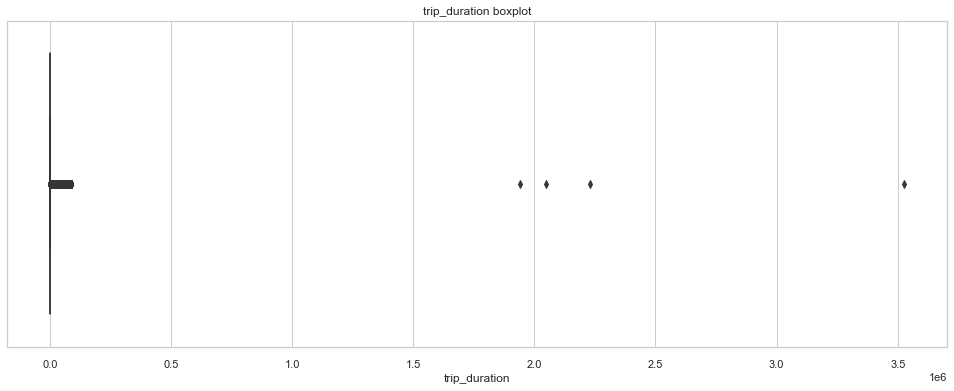

In [97]:
# Target feature
plt.figure(figsize=(15,6))
plt.style.use('seaborn-colorblind')
sns.boxplot(trainf.trip_duration)
plt.title("trip_duration boxplot")
plt.savefig("images/trip_duration boxplot.png", bbox_inches ="tight")
plt.show()

In [99]:
# Target feature
trainf.trip_duration.sort_values(ascending=False)

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
            ...   
269418           1
467645           1
533799           1
726971           1
311745           1
Name: trip_duration, Length: 1458644, dtype: int64

There are 4 outliers for this feature.

### vendor_id, passenger_count <a class="anchor" id="uni_vendor_id"></a>

In [434]:
def annotate_percent(plot, data):
    percentage = list(round(data.value_counts(normalize = True) * 100, 1))
    patches = plot.patches
    for i in range(len(patches)):
        x = patches[i].get_x() + patches[i].get_width()/2
        y = patches[i].get_height()+.05
        plot.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')

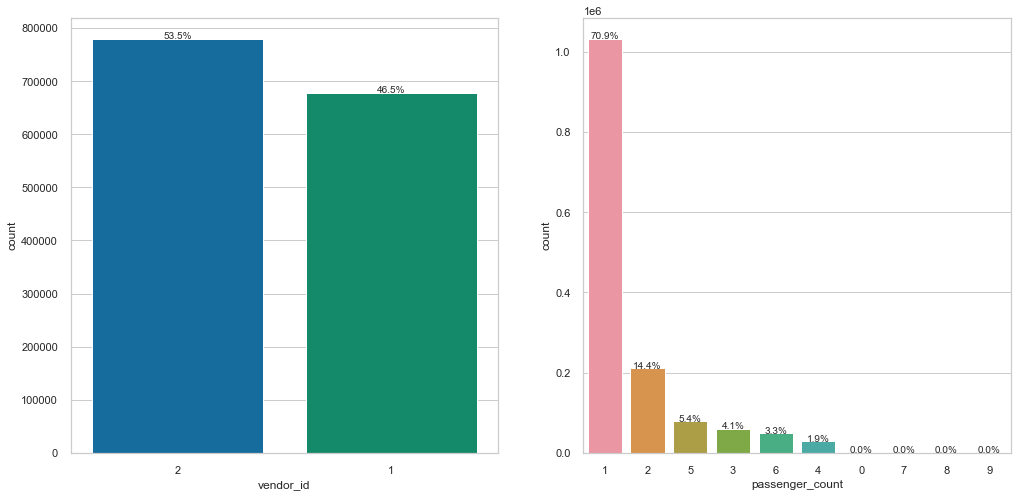

In [148]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
i = 0 
for cat in ['vendor_id', 'passenger_count']:
    plot = sns.countplot(trainf[cat], ax=ax[i], order = trainf[cat].value_counts().index)
    i += 1 
    annotate_percent(plot, trainf[cat])
plt.savefig("images/vendor & passenger.png", bbox_inches ="tight")    
plt.show()

In [151]:
trainf.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
8          1
9          1
Name: passenger_count, dtype: int64

- vendor_id 2 has slightly more trips, but they are similar in distribution
- most of the time, there's 1 passenger in a ride
- however, there are 60 rides with 0 passenger - outlier, error

### store_and_fwd_flag, time_of_day <a class="anchor" id="uni_store"></a>

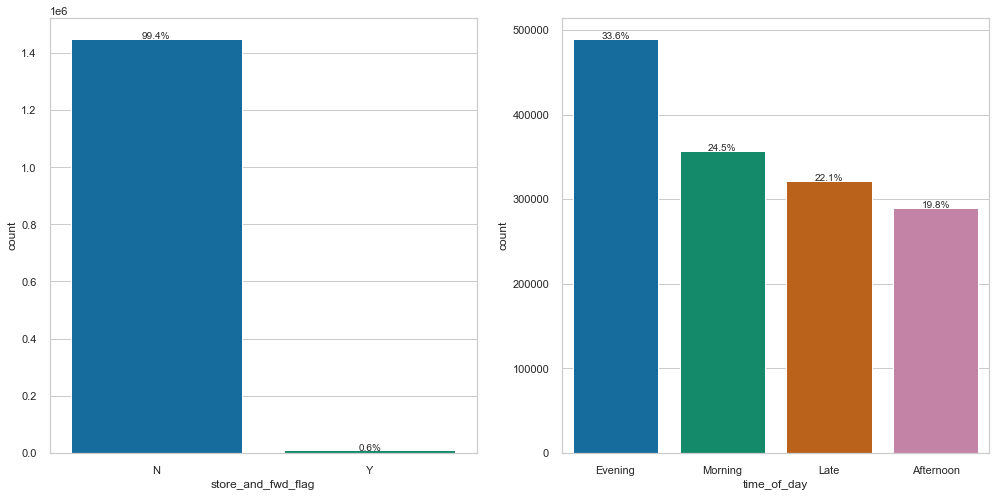

In [152]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
i = 0 
for cat in ['store_and_fwd_flag', 'time_of_day']:
    plot = sns.countplot(trainf[cat], ax=ax[i], order = trainf[cat].value_counts().index)
    i += 1 
    annotate_percent(plot, trainf[cat])
plt.savefig("images/store & time.png", bbox_inches ="tight")    
plt.show()

- Less than 1% of rides were stored before being forwarded to the system
- Evening has the most trips, followed by morning
- Morning: work starts, evening: work ends

### pickup_day_name, is_weekend <a class="anchor" id="uni_pickup1"></a>

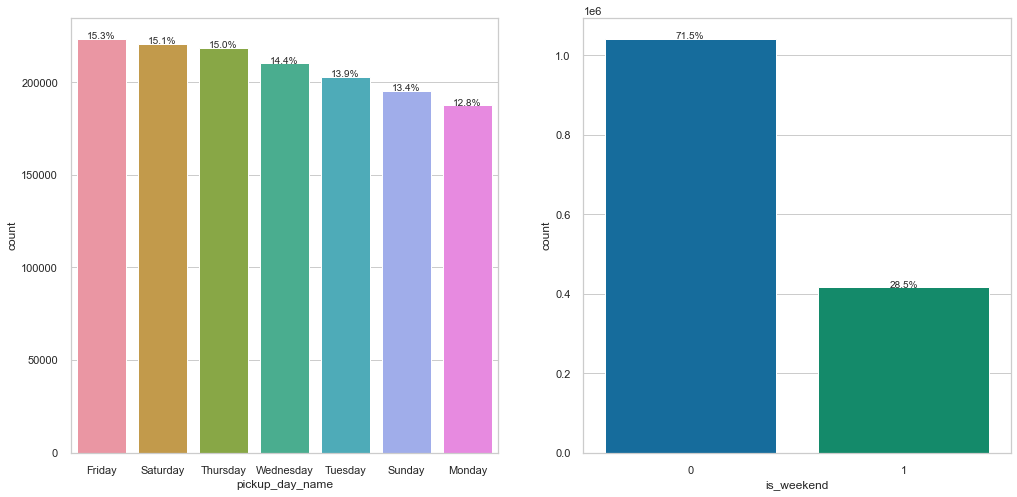

In [157]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
i = 0 
for cat in ['pickup_day_name', 'is_weekend']:
    plot = sns.countplot(trainf[cat], ax=ax[i], order = trainf[cat].value_counts().index)
    i += 1 
    annotate_percent(plot, trainf[cat])
plt.savefig("images/pickup day & weekend.png", bbox_inches ="tight")    
plt.show()

- Friday is the busiest day, followed by Saturday. There are more trips during the weekend- 

### pickup_day, pickup_month <a class="anchor" id="uni_pickup2"></a>

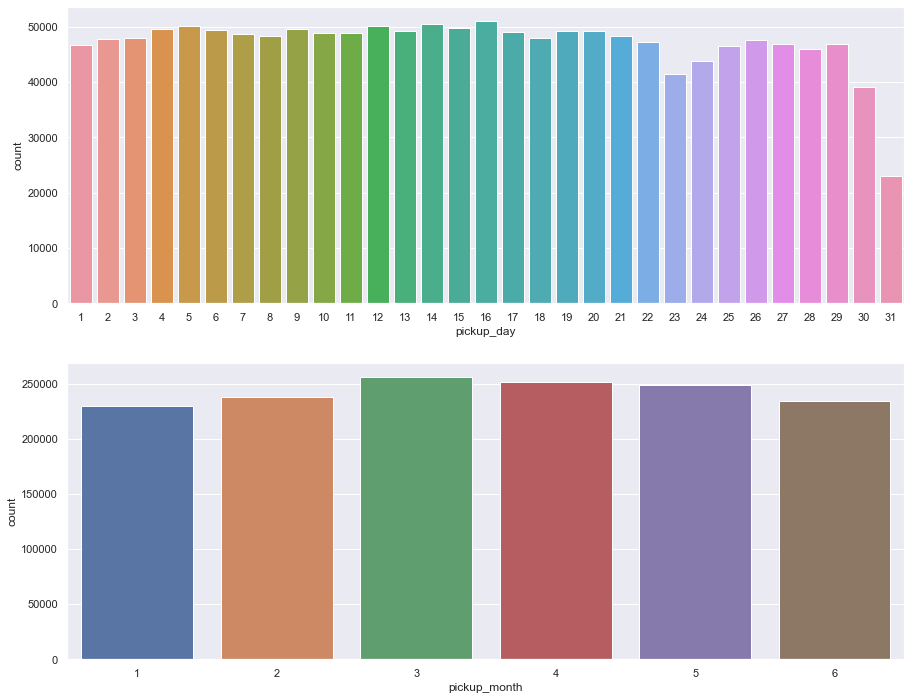

In [429]:
fig, ax = plt.subplots(2,1,figsize=(15,12))
i = 0 
for cat in ['pickup_day', 'pickup_month']:
    plot = sns.countplot(trainf[cat], ax=ax[i])
    i += 1 
#     annotate_percent(plot, trainf[cat])
plt.savefig("images/pickup day & month.png", bbox_inches ="tight")    
plt.show()

- There are no obvious pattern for these two features

### pickup_hour, pickup_minute <a class="anchor" id="uni_pickup3"></a>

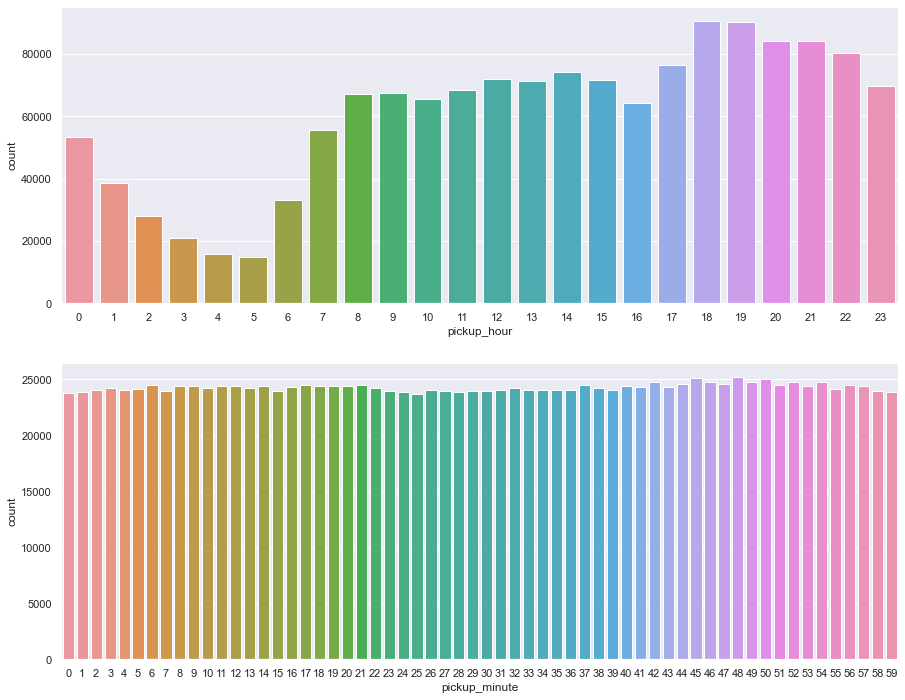

In [430]:
fig, ax = plt.subplots(2,1,figsize=(15,12))
i = 0 
for cat in ['pickup_hour', 'pickup_minute']:
    plot = sns.countplot(trainf[cat], ax=ax[i])
    i += 1 
#     annotate_percent(plot, trainf[cat])
plt.savefig("images/pickup hour & minute.png", bbox_inches ="tight")    
plt.show()

- The peak hour for trips are doing the end of working hours (6pm-7pm) where workers are returning home from their offices
- No obvious pattern for pickup_minute

### trip_distance <a class="anchor" id="uni_distance"></a>

In [176]:
trainf.trip_distance.value_counts()

0.000000     5897
0.000424       50
0.000424       35
0.000424       35
0.000424       21
             ... 
5.461542        1
1.150977        1
21.485180       1
1.398965        1
2.115674        1
Name: trip_distance, Length: 1452363, dtype: int64

- For 0 km distances, either cancelled trips/system error/no gps available there

### Events <a class="anchor" id="uni_events"></a>

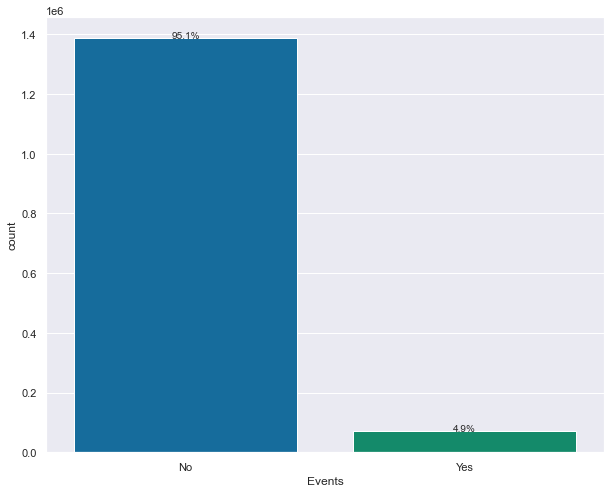

In [438]:
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
plot = sns.countplot(trainf.Events)
annotate_percent(plot, trainf.Events)
# plt.title("trip_duration histogram")
plt.savefig("images/weather.png", bbox_inches ="tight")
plt.show()

## Bivariate Analysis <a class="anchor" id="eda_bi"></a>

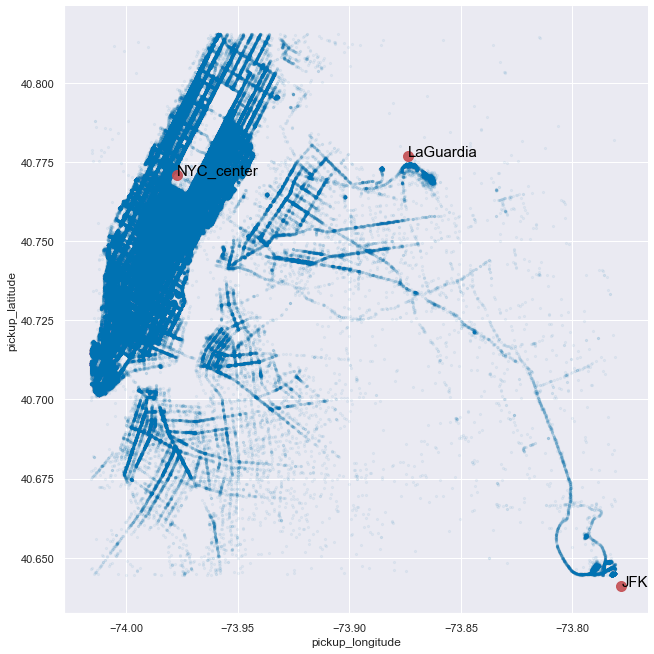

In [472]:
sns.lmplot(x="pickup_longitude", y="pickup_latitude", fit_reg=False, 
           size=9, scatter_kws={'alpha':0.05,'s':5}, data=trainf[(
                 trainf.pickup_longitude>trainf.pickup_longitude.quantile(0.005))
               &(trainf.pickup_longitude<trainf.pickup_longitude.quantile(0.995))
               &(trainf.pickup_latitude>trainf.pickup_latitude.quantile(0.005))                           
               &(trainf.pickup_latitude<trainf.pickup_latitude.quantile(0.995))])

JFK_location=[-73.778203,40.641165]
LaGuardia_location = [-73.873923,40.776935]
NYC_center = [-73.977282,40.770940]

### transform locations to dataframe 
locations=pd.DataFrame({'JFK':JFK_location,
             'LaGuardia':LaGuardia_location,
             'NYC':NYC_center}).T
locations.columns=['lon','lat']
###

plt.plot(JFK_location[0],JFK_location[1],'o', color = 'r',alpha=0.9,markersize=10)
plt.plot(LaGuardia_location[0],LaGuardia_location[1],'o', color = 'r',alpha=0.9,markersize=10)
plt.plot(NYC_center[0],NYC_center[1],'o', color = 'r',alpha=0.9,markersize=10)
plt.annotate('NYC_center', (NYC_center[0], NYC_center[1]), color = 'black', fontsize = 15)
plt.annotate('LaGuardia', (LaGuardia_location[0], LaGuardia_location[1]), color = 'black', fontsize = 15)
plt.annotate('JFK', (JFK_location[0], JFK_location[1]), color = 'black', fontsize = 15)

plt.savefig("images/map.png", bbox_inches ="tight")

plt.show()

### trip_duration vs vendor_id <a class="anchor" id="bi1"></a>

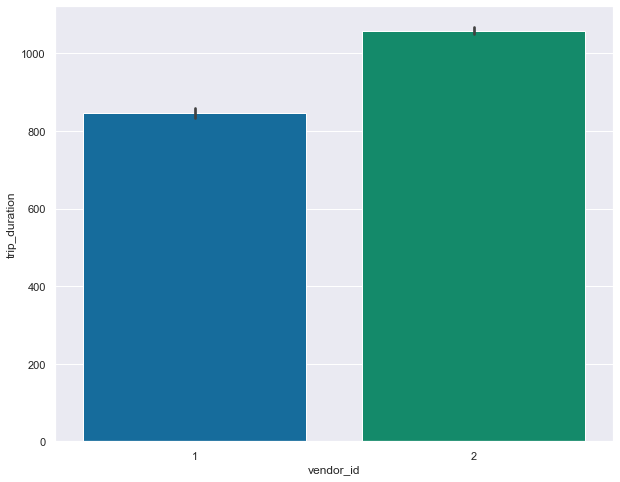

In [457]:
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.barplot(y='trip_duration', x='vendor_id', data=trainf, estimator=np.mean)
plt.savefig("images/trip_vendor.png", bbox_inches ="tight")
plt.show()

<Figure size 720x576 with 0 Axes>

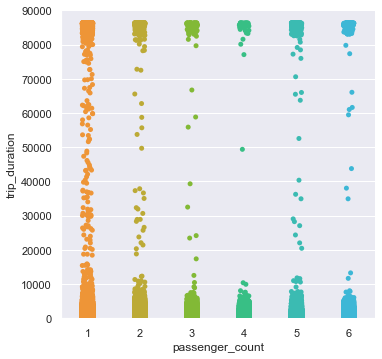

In [482]:
# trip_duration vs passenger_count
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.catplot(y='trip_duration', x='passenger_count', data=trainf)
plt.ylim(bottom=0, top=90000)
plt.xlim(0.5, 6.5)
plt.savefig("images/trip_passenger.png", bbox_inches ="tight")
plt.show()

<Figure size 720x576 with 0 Axes>

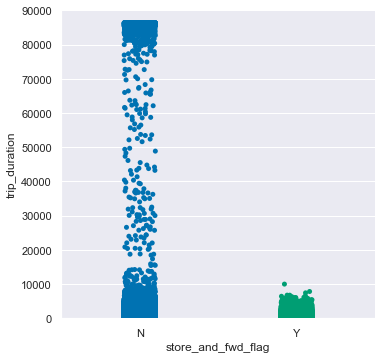

In [484]:
# trip_duration vs store_and_fwd_flag
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.catplot(y='trip_duration', x='store_and_fwd_flag', data=trainf)
plt.ylim(bottom=0, top=90000)
plt.savefig("images/trip_storer.png", bbox_inches ="tight")
plt.show()

<Figure size 720x576 with 0 Axes>

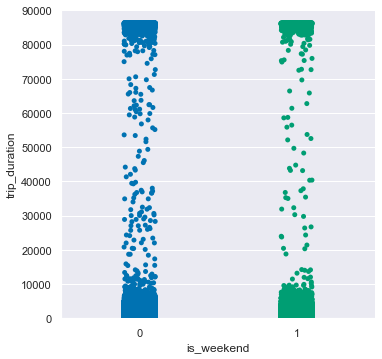

In [486]:
# trip_duration vs is_weekend
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.catplot(y='trip_duration', x='is_weekend', data=trainf)
plt.ylim(bottom=0, top=90000)
plt.savefig("images/trip_weekend.png", bbox_inches ="tight")
plt.show()

<Figure size 720x576 with 0 Axes>

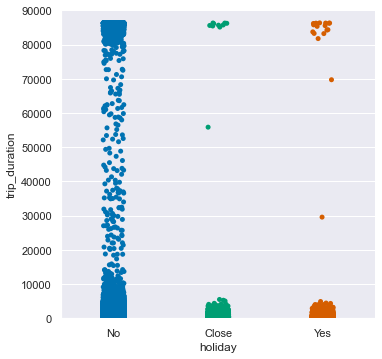

In [487]:
# trip_duration vs holiday
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.catplot(y='trip_duration', x='holiday', data=trainf)
plt.ylim(bottom=0, top=90000)
plt.savefig("images/trip_holiday.png", bbox_inches ="tight")
plt.show()

<Figure size 720x576 with 0 Axes>

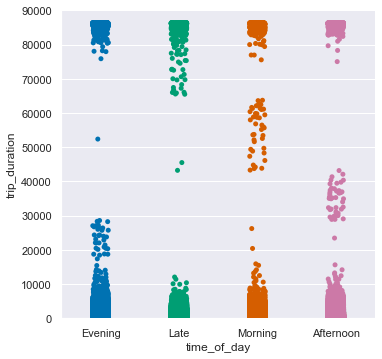

In [488]:
# trip_duration vs time_of_day
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.catplot(y='trip_duration', x='time_of_day', data=trainf)
plt.ylim(bottom=0, top=90000)
plt.savefig("images/trip_timeofday.png", bbox_inches ="tight")
plt.show()

<Figure size 720x576 with 0 Axes>

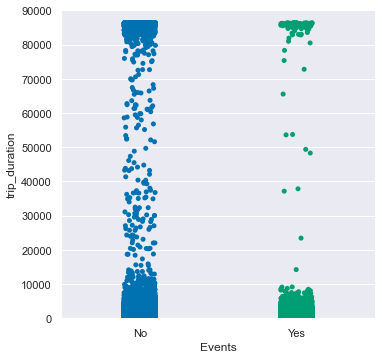

In [491]:
# trip_duration vs events
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.catplot(y='trip_duration', x='Events', data=trainf)
plt.ylim(bottom=0, top=90000)
plt.savefig("images/trip_events.png", bbox_inches ="tight")
plt.show()

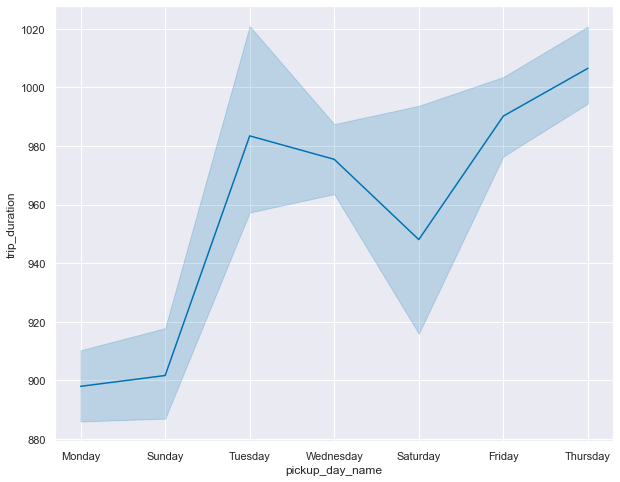

In [493]:
# trip_duration vs pickup_day_name
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.lineplot(y='trip_duration', x='pickup_day_name', data=trainf)
# plt.ylim(bottom=0, top=90000)
plt.savefig("images/trip_pickupdayname.png", bbox_inches ="tight")
plt.show()

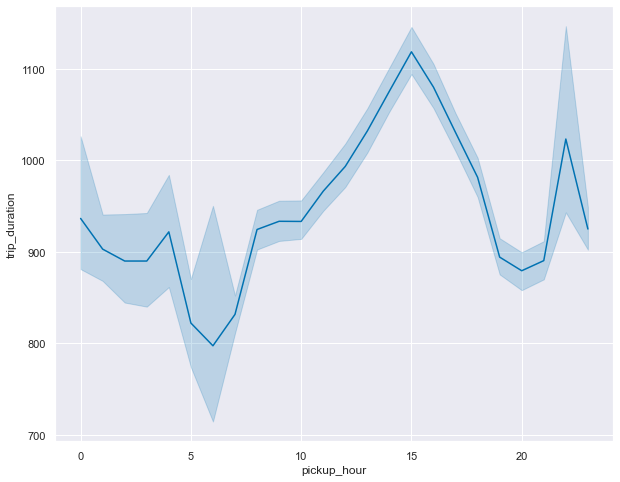

In [495]:
# trip_duration vs pickup_hour
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.lineplot(y='trip_duration', x='pickup_hour', data=trainf)
# plt.ylim(bottom=0, top=90000)
plt.savefig("images/trip_pickuphour.png", bbox_inches ="tight")
plt.show()

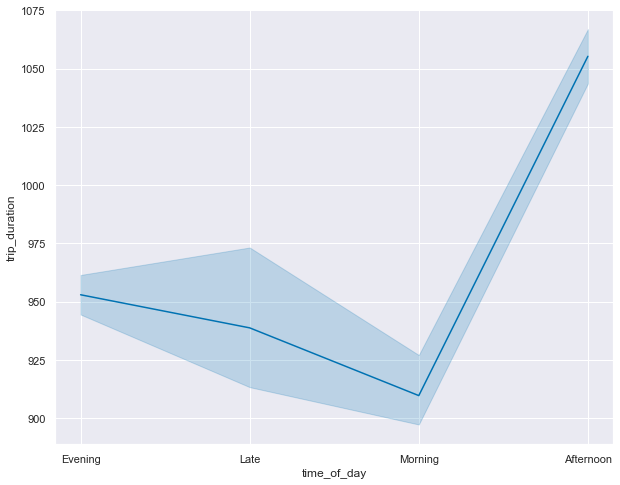

In [496]:
# trip_duration vs time_of_day
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.lineplot(y='trip_duration', x='time_of_day', data=trainf)
# plt.ylim(bottom=0, top=90000)
plt.savefig("images/trip_timetime.png", bbox_inches ="tight")
plt.show()

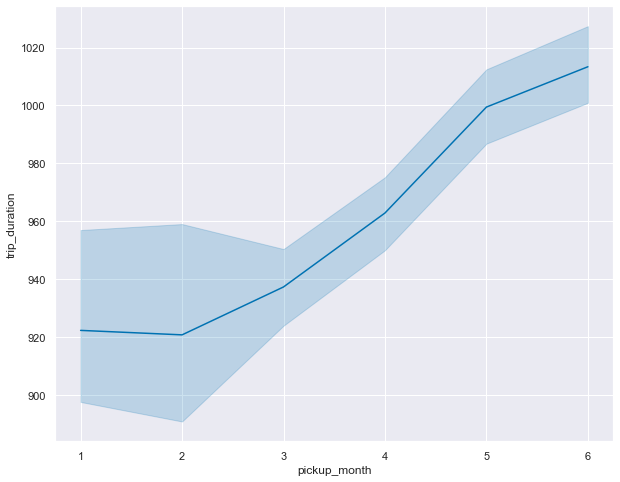

In [498]:
# trip_duration vs pickup_month
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.lineplot(y='trip_duration', x='pickup_month', data=trainf)
# plt.ylim(bottom=0, top=90000)
plt.savefig("images/trip_pickupmonth.png", bbox_inches ="tight")
plt.show()

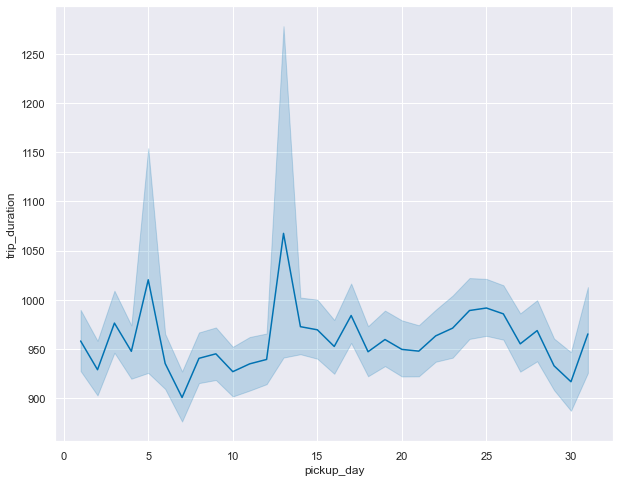

In [499]:
# trip_duration vs pickup_day
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.lineplot(y='trip_duration', x='pickup_day', data=trainf)
# plt.ylim(bottom=0, top=90000)
plt.savefig("images/trip_pickupday.png", bbox_inches ="tight")
plt.show()

<Figure size 720x576 with 0 Axes>

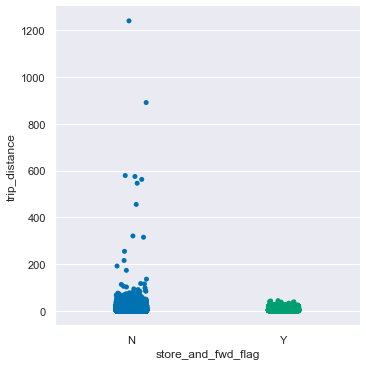

In [500]:
# distance vs store_and_fwd_flag
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.catplot(y='trip_distance', x='store_and_fwd_flag', data=trainf)
# plt.ylim(bottom=0, top=90000)
plt.savefig("images/dist_store.png", bbox_inches ="tight")
plt.show()

<Figure size 720x576 with 0 Axes>

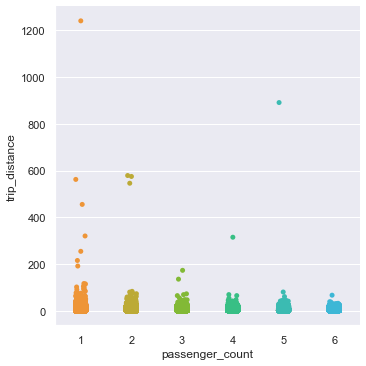

In [502]:
# distance vs passenger_count
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.catplot(y='trip_distance', x='passenger_count', data=trainf)
plt.xlim(0.5, 6.5)
plt.savefig("images/dist_passenger.png", bbox_inches ="tight")
plt.show()

<Figure size 720x576 with 0 Axes>

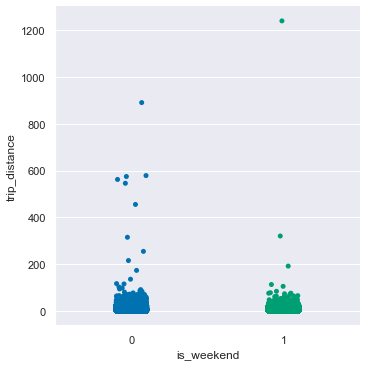

In [503]:
# distance vs is_weekend
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.catplot(y='trip_distance', x='is_weekend', data=trainf)
# plt.ylim(bottom=0, top=90000)
plt.savefig("images/dist_weekend.png", bbox_inches ="tight")
plt.show()

<Figure size 720x576 with 0 Axes>

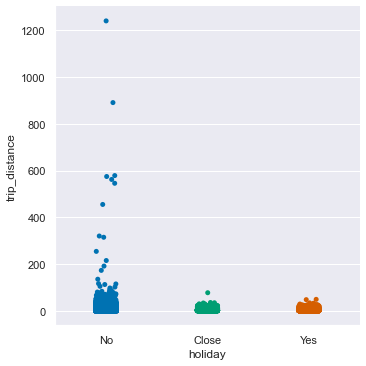

In [504]:
# distance vs holiday
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.catplot(y='trip_distance', x='holiday', data=trainf)
# plt.ylim(bottom=0, top=90000)
plt.savefig("images/dist_holi.png", bbox_inches ="tight")
plt.show()

<Figure size 720x576 with 0 Axes>

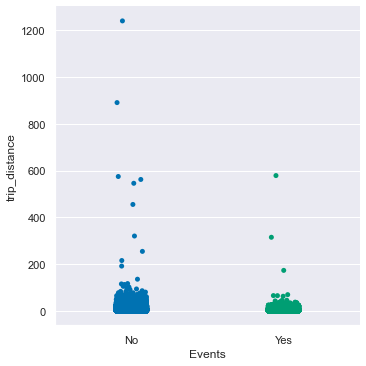

In [505]:
# distance vs events
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.catplot(y='trip_distance', x='Events', data=trainf)
# plt.ylim(bottom=0, top=90000)
plt.savefig("images/dist_events.png", bbox_inches ="tight")
plt.show()

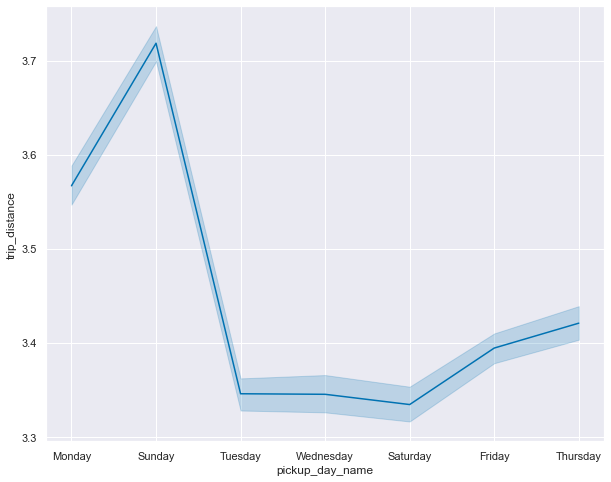

In [506]:
# distance vs pickup_day_name
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.lineplot(y='trip_distance', x='pickup_day_name', data=trainf)
# plt.ylim(bottom=0, top=90000)
plt.savefig("images/dist_pickupdayname.png", bbox_inches ="tight")
plt.show()

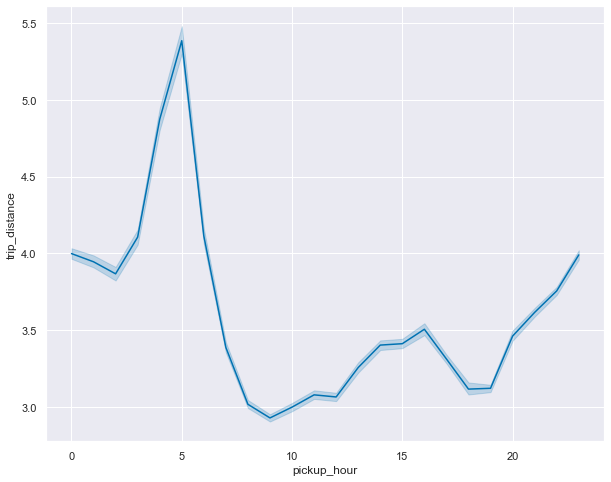

In [507]:
# distance vs pickup_hour
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.lineplot(y='trip_distance', x='pickup_hour', data=trainf)
# plt.ylim(bottom=0, top=90000)
plt.savefig("images/dist_pickuphour.png", bbox_inches ="tight")
plt.show()

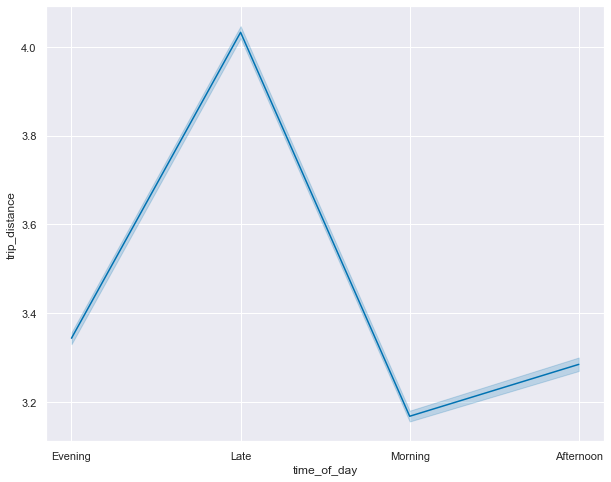

In [508]:
# distance vs time_of_day
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.lineplot(y='trip_distance', x='time_of_day', data=trainf)
# plt.ylim(bottom=0, top=90000)
plt.savefig("images/dist_timeofday.png", bbox_inches ="tight")
plt.show()

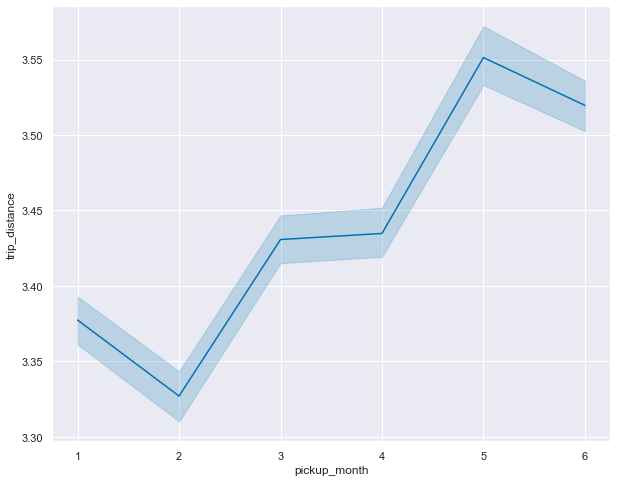

In [509]:
# distance vs pickup_month
plt.figure(figsize=(10,8))
plt.style.use('seaborn-colorblind')
sns.lineplot(y='trip_distance', x='pickup_month', data=trainf)
# plt.ylim(bottom=0, top=90000)
plt.savefig("images/dist_pickupmonth.png", bbox_inches ="tight")
plt.show()

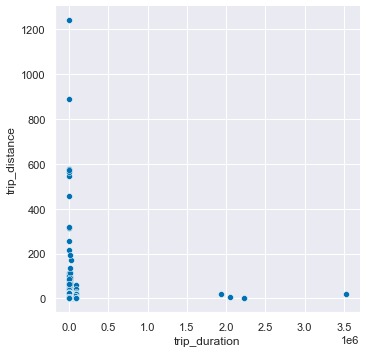

In [511]:
sns.relplot(y=trainf.trip_distance,x='trip_duration',data=trainf)
plt.savefig("images/distancetrip.png", bbox_inches ="tight")

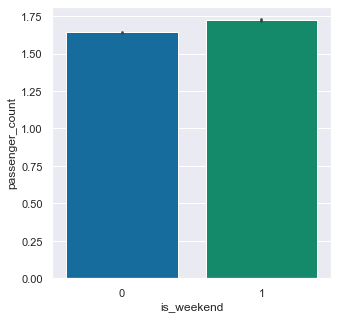

In [514]:
sns.barplot(y='passenger_count',x='is_weekend',data=trainf)
plt.savefig("images/pass_weekend.png", bbox_inches ="tight")

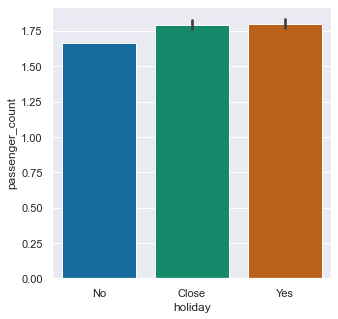

In [515]:
sns.barplot(y='passenger_count',x='holiday',data=trainf)
plt.savefig("images/pass_holiday.png", bbox_inches ="tight")

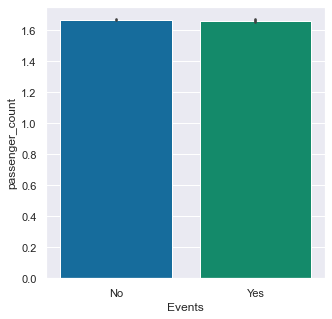

In [516]:
sns.barplot(y='passenger_count',x='Events',data=trainf)
plt.savefig("images/pass_events.png", bbox_inches ="tight")

# Simple ML Models <a class="anchor" id="mlmodel"></a>

In [ ]:
trainf.columns

In [ ]:
# split data to X and y - remove redundant columns
X = trainf.drop(['trip_duration', 'pickup_datetime', 'pickup_day_name'], axis = 1)
y = trainf['trip_duration']
testf2 = testf.drop(['pickup_datetime', 'pickup_day_name'], axis = 1)

In [ ]:
# Check for data shape
print("Train set shape:", X.shape)
print("Test set shape:", testf2.shape)

In [ ]:
# convert to dummies
X_dum = pd.get_dummies(X, drop_first=True)
X_test = pd.get_dummies(testf2, drop_first=True)
print("Train set shape:", X_dum.shape)
print("Test set shape:", X_test.shape)

In [ ]:
# split to train and test
X_train, X_val, y_train, y_val = train_test_split(X_dum, y, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

In [ ]:
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(np.square(np.subtract(np.log1p(y_true), np.log1p(y_pred)))))

def eval_scores(model, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    rmsle_train = rmsle(y_train, y_pred_train)
    rmsle_test = rmsle(y_test, y_pred_test)
    

    print("####################################\n          TRAINING SCORES\n####################################")
    print("R2 Score: {:.4f}".format(r2_train))
    print("RMSE Score: {:.4f}".format(rmse_train))
    print("RMSLE Score: {:.4f}".format(rmsle_train))
    print()
    print("####################################\n        VALIDATION SCORES\n####################################")
    print("R2 Score: {:.4f}".format(r2_test))
    print("RMSE Score: {:.4f}".format(rmse_test))
    print("RMSLE Score: {:.4f}".format(rmsle_test))
    
    scores = {'r2_train': r2_train, 'r2_test': r2_test, \
              'rmse_train': rmse_train, 'rmse_test': rmse_test, \
              'rmsle_train': rmsle_train, 'rmsle_test': rmsle_test}
    
    return y_pred_train, y_pred_test, scores

## Linear Regression <a class="anchor" id="ml_lr"></a>

In [259]:
# Linear regression
scores_dict = {}
model_lr = LinearRegression().fit(X_train, y_train)
y_pred_train_lr, y_pred_val_lr, scores_lr = eval_scores(model_lr, X_train, X_val, y_train, y_val)

scores_dict['Linear Regression'] = scores_lr

####################################
            COEFFICIENTS
####################################
Intercept: 123651.72377746481
Slope:     192.41302842484848

####################################
          TRAINING SCORES
####################################
R2 Score: 0.0080
RMSE Score: 5723.4164
RMSLE Score: 0.6844

####################################
        VALIDATION SCORES
####################################
R2 Score: 0.0263
RMSE Score: 3222.0308
RMSLE Score: 0.6848


## Polynomial Linear <a class="anchor" id="ml_polylin"></a>

In [268]:
# polynomial linear
model_polylin = make_pipeline(PolynomialFeatures(), LinearRegression()).fit(X_train, y_train)
y_pred_train_polylin, y_pred_val_polylin, scores_polylin = eval_scores(model_polylin, X_train, X_val, y_train, y_val)

scores_dict['Polynomial Linear'] = scores_polylin

####################################
          TRAINING SCORES
####################################
R2 Score: 0.0104
RMSE Score: 5716.2603
RMSLE Score: 0.6201

####################################
        VALIDATION SCORES
####################################
R2 Score: 0.0299
RMSE Score: 3216.1390
RMSLE Score: 0.6207


## Polynomial Lasso <a class="anchor" id="ml_polylas"></a>

In [269]:
# polynomial lasso
model_polylas = make_pipeline(PolynomialFeatures(), Lasso()).fit(X_train, y_train)
y_pred_train_polylas, y_pred_val_polylas, scores_polylas = eval_scores(model_polylas, X_train, X_val, y_train, y_val)

scores_dict['Polynomial Lasso'] = scores_polylas

####################################
          TRAINING SCORES
####################################
R2 Score: 0.0099
RMSE Score: 5717.8931
RMSLE Score: 0.6322

####################################
        VALIDATION SCORES
####################################
R2 Score: 0.0292
RMSE Score: 3217.2993
RMSLE Score: 0.6329


## Polynomial Ridge <a class="anchor" id="ml_polyr"></a>

In [270]:
# polynomial ridge
model_polyr = make_pipeline(PolynomialFeatures(), Ridge()).fit(X_train, y_train)
y_pred_train_polyr, y_pred_val_polyr, scores_polyr = eval_scores(model_polyr, X_train, X_val, y_train, y_val)

scores_dict['Polynomial Ridge'] = scores_polyr

####################################
          TRAINING SCORES
####################################
R2 Score: 0.0103
RMSE Score: 5716.5329
RMSLE Score: 0.6225

####################################
        VALIDATION SCORES
####################################
R2 Score: 0.0276
RMSE Score: 3220.0357
RMSLE Score: 0.6232


## Polynomial ElasticNet <a class="anchor" id="ml_polyen"></a>

In [272]:
# polynomial elasticnet
model_polyen = make_pipeline(PolynomialFeatures(), ElasticNet()).fit(X_train, y_train)
y_pred_train_polyen, y_pred_val_polyen, scores_polyen = eval_scores(model_polyen, X_train, X_val, y_train, y_val)

scores_dict['Polynomial ElasticNet'] = scores_polyen

####################################
          TRAINING SCORES
####################################
R2 Score: 0.0097
RMSE Score: 5718.3272
RMSLE Score: 0.6378

####################################
        VALIDATION SCORES
####################################
R2 Score: 0.0290
RMSE Score: 3217.6819
RMSLE Score: 0.6386


## Decision Tree <a class="anchor" id="ml_dt"></a>

In [274]:
# decision tree
model_dt = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)
y_pred_train_dt, y_pred_val_dt, scores_dt = eval_scores(model_dt, X_train, X_val, y_train, y_val)

scores_dict['Decision Tree'] = scores_dt

####################################
          TRAINING SCORES
####################################
R2 Score: 1.0000
RMSE Score: 0.0000
RMSLE Score: 0.0000

####################################
        VALIDATION SCORES
####################################
R2 Score: -9.6529
RMSE Score: 10657.6273
RMSLE Score: 0.5955


In [282]:
model_dt.feature_importances_

array([7.26817273e-04, 6.69400791e-03, 1.57475135e-01, 1.46402460e-01,
       4.31225242e-02, 3.86895297e-01, 5.29558304e-03, 1.15774678e-02,
       7.94989932e-03, 1.00360277e-02, 1.62128035e-02, 1.09396346e-03,
       2.00133363e-01, 6.29344880e-06, 2.55583029e-03, 1.17508018e-03,
       1.14047902e-03, 3.59904255e-04, 2.52980336e-04, 8.94082686e-04])

Text(0, 0.5, 'feature')

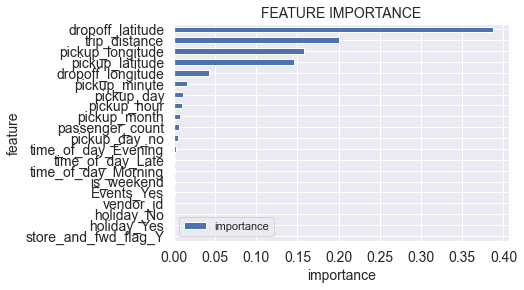

In [283]:
# plot feature importance 

pd.DataFrame({'feature': X_train.columns, \
              'importance': model_dt.feature_importances_})\
              .sort_values('importance')\
              .set_index('feature')\
              .plot(kind='barh', fontsize=14)

plt.title('FEATURE IMPORTANCE',fontsize=14 )
plt.xlabel('importance',fontsize=14)
plt.ylabel('feature',fontsize=14)

In [281]:
# random forest
# model_rf = RandomForestClassifier(random_state=42, max_depth=6, min_samples_split=100).fit(X_train, y_train)
# y_pred_train_rf, y_pred_val_rf, scores_rf = eval_scores(model_rf, X_train, X_val, y_train, y_val)

# scores_dict['Random Forest'] = scores_rf

In [285]:
# svm
# model_svm = SVR(gamma='auto', random_state=42).fit(X_train, y_train)
# y_pred_train_svm, y_pred_val_svm, scores_svm = eval_scores(model_svm, X_train, X_val, y_train, y_val)

# scores_dict['SVM'] = scores_svm

## XGBoost <a class="anchor" id="ml_xgb"></a>

In [320]:
# XGBoost
train_xgb = xgb.DMatrix(X_train, label=y_train)
valid_xgb = xgb.DMatrix(X_val, label=y_val)
test_xgb = xgb.DMatrix(X_test)
val_list = [(train_xgb, 'train'), (valid_xgb, 'valid')]

In [333]:
model_xgb1 = xgb.XGBRegressor(n_estimators=250, max_depth=6, learning_rate=0.09, objective='reg:squaredlogerror', \
                              eval_metric='rmsle', verbosity=0, early_stopping_rounds=30, \
                              random_state=42).fit(X_train, y_train)
y_pred_train_xgb, y_pred_val_xgb, scores_xgb = eval_scores(model_xgb1, X_train, X_val, y_train, y_val)

scores_dict['XGB'] = scores_xgb

####################################
          TRAINING SCORES
####################################
R2 Score: 0.0035
RMSE Score: 5736.3268
RMSLE Score: 0.5223

####################################
        VALIDATION SCORES
####################################
R2 Score: 0.0109
RMSE Score: 3247.4845
RMSLE Score: 0.5243


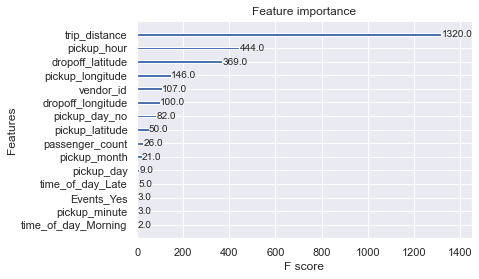

In [381]:
xgb.plot_importance(model_xgb1)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [321]:
# parameters from paper
params = {'max_depth':6, 
         'learning_rate': 0.09,
         'objective': 'reg:squaredlogerror',
         'eval_metric': 'rmsle',
         'verbosity': 0}

model_xgb = xgb.train(params, train_xgb, evals=val_list, num_boost_round=250, \
                      early_stopping_rounds=30, maximize=False, verbose_eval=10)
print('score = %1.5f, n_boost_round = %d.'%(model_xgb.best_score, model_xgb.best_iteration))

[0]	train-rmsle:6.03972	valid-rmsle:6.03977
[10]	train-rmsle:5.30993	valid-rmsle:5.31001
[20]	train-rmsle:4.59737	valid-rmsle:4.59752
[30]	train-rmsle:3.90665	valid-rmsle:3.90686
[40]	train-rmsle:3.24422	valid-rmsle:3.24450
[50]	train-rmsle:2.61942	valid-rmsle:2.61976
[60]	train-rmsle:2.04612	valid-rmsle:2.04662
[70]	train-rmsle:1.54619	valid-rmsle:1.54695
[80]	train-rmsle:1.14644	valid-rmsle:1.14743
[90]	train-rmsle:0.86948	valid-rmsle:0.87061
[100]	train-rmsle:0.70770	valid-rmsle:0.70899
[110]	train-rmsle:0.62309	valid-rmsle:0.62462
[120]	train-rmsle:0.57917	valid-rmsle:0.58081
[130]	train-rmsle:0.55725	valid-rmsle:0.55890
[140]	train-rmsle:0.54701	valid-rmsle:0.54865
[150]	train-rmsle:0.54226	valid-rmsle:0.54391
[160]	train-rmsle:0.53978	valid-rmsle:0.54143
[170]	train-rmsle:0.53691	valid-rmsle:0.53859
[180]	train-rmsle:0.53343	valid-rmsle:0.53517
[190]	train-rmsle:0.53047	valid-rmsle:0.53228
[200]	train-rmsle:0.52872	valid-rmsle:0.53060
[210]	train-rmsle:0.52678	valid-rmsle:0.52868

## Multilayer Perceptron <a class="anchor" id="ml_mlp"></a>

In [294]:
X_train_np = np.array(X_train)
X_val_np = np.array(X_val)
X_test_np = np.array(X_test)

y_train_np = np.array(y_train)
y_val_np = np.array(y_val)
# y_test_np = np.array(y_test)

In [297]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

modelB = tf.keras.Sequential([
        
    tf.keras.layers.Dense(16, activation='relu', kernel_initializer='normal', input_shape=[len(X_train_np[0])]),
#     tf.keras.layers.Dense(64, activation='relu', kernel_initializer='truncated_normal'),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(1, kernel_initializer='normal')
        
  ])

modelB.compile(
    loss='mean_squared_logarithmic_error', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),  metrics=['mean_squared_logarithmic_error']) 

modelB.fit(X_train_np, y_train_np,
                    epochs=10, 
                    batch_size=100,
                    validation_data=(X_val_np, y_val_np), 
                    verbose=1)

Epoch 1/10
10940/10940 [==============================] - 7s 602us/step - loss: 42.4548 - mean_squared_logarithmic_error: 42.4548 - val_loss: 42.4553 - val_mean_squared_logarithmic_error: 42.4553
Epoch 2/10
10940/10940 [==============================] - 7s 599us/step - loss: 42.4550 - mean_squared_logarithmic_error: 42.4550 - val_loss: 42.4553 - val_mean_squared_logarithmic_error: 42.4553
Epoch 3/10
10940/10940 [==============================] - 7s 597us/step - loss: 42.4549 - mean_squared_logarithmic_error: 42.4549 - val_loss: 42.4553 - val_mean_squared_logarithmic_error: 42.4553
Epoch 4/10
10940/10940 [==============================] - 7s 600us/step - loss: 42.4550 - mean_squared_logarithmic_error: 42.4550 - val_loss: 42.4553 - val_mean_squared_logarithmic_error: 42.4553
Epoch 5/10
10940/10940 [==============================] - 6s 594us/step - loss: 42.4550 - mean_squared_logarithmic_error: 42.4550 - val_loss: 42.4553 - val_mean_squared_logarithmic_error: 42.4553
Epoch 6/10
10940/109

In [300]:
modelB.evaluate(X_val_np, y_val_np)

11396/11396 [==============================] - 5s 397us/step - loss: 42.4553 - mean_squared_logarithmic_error: 42.4553


In [335]:
y_pred_train_mlp = modelB.predict(X_train_np)
y_pred_test_mlp = modelB.predict(X_val_np)

In [343]:
r2_train_mlp = r2_score(y_train_np, y_pred_train_mlp)
r2_test_mlp = r2_score(y_val_np, y_pred_test_mlp)
rmse_train_mlp = np.sqrt(mean_squared_error(y_train_np, y_pred_train_mlp))
rmse_test_mlp = np.sqrt(mean_squared_error(y_val_np, y_pred_test_mlp))
rmsle_train_mlp = np.sqrt(modelB.evaluate(X_train_np, y_train_np)[0])
rmsle_test_mlp = np.sqrt(modelB.evaluate(X_val_np, y_val_np)[0])

scores_dict['MLP'] = {'r2_train': r2_train_mlp, 'r2_test': r2_test_mlp, \
                    'rmse_train': rmse_train_mlp, 'rmse_test': rmse_test_mlp, \
                    'rmsle_train': rmsle_train_mlp, 'rmsle_test': rmsle_test_mlp}

11396/11396 [==============================] - 12s 1ms/step - loss: 42.4553 - mean_squared_logarithmic_error: 42.4553


## Evaluation Scores <a class="anchor" id="ml_eval"></a>

In [344]:
scores_df = pd.DataFrame.from_dict(scores_dict, orient='index').reset_index().rename(columns={'index': 'model'})
scores_df = scores_df.sort_values(by='rmsle_test', ascending=True, ignore_index=True)
scores_df.round(4)

,model,r2_train,r2_test,rmse_train,rmse_test,rmsle_train,rmsle_test
0,XGB,0.0035,0.0109,5736.3268,3247.4845,0.5223,0.5243
1,Decision Tree,1.0000,-9.6529,0.0000,10657.6273,0.0000,0.5955
2,Polynomial Linear,0.0104,0.0299,5716.2603,3216.1390,0.6201,0.6207
3,Polynomial Regression,0.0104,0.0299,5716.2606,3216.1368,0.6201,0.6208
4,Polynomial Ridge,0.0103,0.0276,5716.5329,3220.0357,0.6225,0.6232
5,Polynomial Lasso,0.0099,0.0292,5717.8931,3217.2993,0.6322,0.6329
6,Polynomial ElasticNet,0.0097,0.0290,5718.3272,3217.6819,0.6378,0.6386
7,Linear Regression,0.0080,0.0263,5723.4164,3222.0308,0.6844,0.6848
8,MLP,-0.0279,-0.0865,5825.9579,3403.6830,6.5157,6.5158


# Hyperparameter Tuning <a class="anchor" id="hyper"></a>

In [388]:
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

params = {'learning_rate': [0.08, 0.09, 0.3, 0.5],
          'gamma': [0],
          'subsample': [0.7, 0.8],
          'colsample_bytree': [1, 0.9],
          'max_depth': [6, 7, 8]
        } 


xgb2 = xgb.XGBRegressor(n_estimators=500, objective='reg:squaredlogerror', eval_metric='rmsle',
                    silent=False, nthread=1)

folds = 5
param_comb = 10

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

random_search = RandomizedSearchCV(xgb2, param_distributions=params, n_iter=param_comb, \
                                   scoring = 'neg_mean_squared_log_error',\
                                   cv=skf.split(X_train, y_train), verbose=3, random_state=42 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.9, gamma=0, learning_rate=0.08, max_depth=7, subsample=0.8; total time= 4.9min
[CV 2/5] END colsample_bytree=0.9, gamma=0, learning_rate=0.08, max_depth=7, subsample=0.8; total time= 4.9min
[CV 3/5] END colsample_bytree=0.9, gamma=0, learning_rate=0.08, max_depth=7, subsample=0.8; total time= 4.9min
[CV 4/5] END colsample_bytree=0.9, gamma=0, learning_rate=0.08, max_depth=7, subsample=0.8; total time= 4.9min
[CV 5/5] END colsample_bytree=0.9, gamma=0, learning_rate=0.08, max_depth=7, subsample=0.8; total time= 4.7min
[CV 1/5] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=8, subsample=0.7; total time= 5.2min
[CV 2/5] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=8, subsample=0.7; total time= 4.9min
[CV 3/5] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=8, subsample=0.7; total time= 5.1min
[CV 4/5] END colsample_bytree=0.9, gamma=0, learning_r

In [389]:
best_xgb = random_search.best_estimator_
params_xgb = random_search.best_params_
score_xgb = random_search.best_score_

print('Best estimator:', best_xgb)
print('Best parameters:', params_xgb)
print('Best score: ', score_xgb)

Best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             eval_metric='rmsle', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.08, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=1, nthread=1,
             num_parallel_tree=1, objective='reg:squaredlogerror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, silent=False, subsample=0.8,
             tree_method='exact', ...)
Best parameters: {'subsample': 0.8, 'max_depth': 6, 'learning_rate': 0.08, 'gamma': 0, 'colsample_bytree': 0.9}
Best score:  -0.2965484846149336


In [390]:
best_xgb.fit(X_train, y_train)
y_pred_train_best, y_pred_val_best, scores_best = eval_scores(best_xgb, X_train, X_val, y_train, y_val)

####################################
          TRAINING SCORES
####################################
R2 Score: 0.0034
RMSE Score: 5736.5592
RMSLE Score: 0.5247

####################################
        VALIDATION SCORES
####################################
R2 Score: 0.0105
RMSE Score: 3248.0943
RMSLE Score: 0.5269


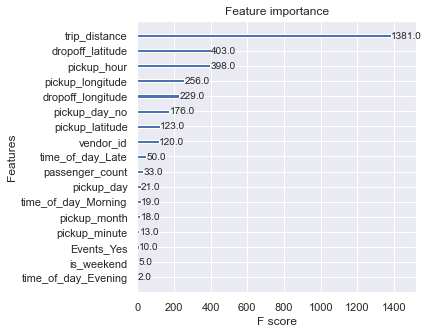

In [391]:
xgb.plot_importance(best_xgb)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [454]:
pd.DataFrame(random_search.cv_results_).head().T

,0,1,2,3,4
mean_fit_time,290.39625,302.478503,266.692399,323.299799,263.520672
std_fit_time,5.322445,7.513974,2.674572,5.733411,2.126646
mean_score_time,0.871198,1.056328,0.688352,1.30369,0.685153
std_score_time,0.029583,0.037458,0.009478,0.027605,0.011647
param_subsample,0.8,0.7,0.7,0.8,0.7
param_max_depth,7,8,7,6,6
param_learning_rate,0.08,0.3,0.08,0.5,0.08
param_gamma,0,0,0,0,0
param_colsample_bytree,0.9,0.9,0.9,0.9,0.9
params,"{'subsample': 0.8, 'max_depth': 7, 'learning_r...","{'subsample': 0.7, 'max_depth': 8, 'learning_r...","{'subsample': 0.7, 'max_depth': 7, 'learning_r...","{'subsample': 0.8, 'max_depth': 6, 'learning_r...","{'subsample': 0.7, 'max_depth': 6, 'learning_r..."


In [450]:
# from sklearn.model_selection import learning_curve

# print ('model : ',best_xgb)
# train_sizes, train_scores, test_scores = learning_curve(best_xgb, X=X_train, y=y_train,\
#                                                         cv=5, n_jobs=1, train_sizes=np.linspace(0.1,1,10))

# print ('train_sizes = ', train_sizes)
# #print ('train_scores = ', train_scores)
# #print ('test_scores = ', test_scores)
# # get mean, std 
# train_mean = np.mean(train_scores, axis = 1 )
# train_std = np.std(train_scores, axis = 1 )
# test_mean = np.mean(test_scores, axis = 1 )
# test_std = np.std(test_scores, axis = 1 )

# # plot 
# plt.plot(train_sizes,
#          train_mean,
#          color='blue', 
#          marker='o',
#          markersize=5,
#          label="training accuracy")
# # plot errors 
# plt.fill_between(train_sizes, 
#                  train_mean + train_std , 
#                  train_mean - train_std , 
#                  alpha = 0.15,
#                  color = 'blue',
#                  label="training accuracy")


# plt.plot(train_sizes,
#          test_mean,
#          color='green',
#          linestyle='--' ,
#          marker='s',
#          markersize=5,
#          label="validation accuracy")

# plt.fill_between(train_sizes, 
#                  test_mean + test_std , 
#                  test_mean -  test_std , 
#                  alpha = 0.15,
#                  color = 'green',
#                  label="validation accuracy")
# plt.grid()
# plt.xlabel('# of train sample')
# plt.ylabel('Accuracy')
# plt.legend(loc = "lower right")
# plt.ylim([0.1,1.2])
# plt.grid()
# plt.show()

In [383]:
# from sklearn.model_selection import StratifiedKFold
# import xgboost as xgb
# from datetime import datetime

# def timer(start_time=None):
#     if not start_time:
#         start_time = datetime.now()
#         return start_time
#     elif start_time:
#         thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
#         tmin, tsec = divmod(temp_sec, 60)
#         print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

# params = {'learning_rate': [0.08, 0.09, 0.3, 0.5],
#           'gamma': [0],
#           'subsample': [0.7, 0.8],
#           'colsample_bytree': [1, 0.9],
#           'max_depth': [6, 7, 8]
#         } 


# xgb3 = xgb.XGBRegressor(n_estimators=500, objective='reg:squaredlogerror', eval_metric='rmsle',
#                     silent=False, nthread=1)

# folds = 3
# param_comb = 5

# skf3 = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

# random_search2 = RandomizedSearchCV(xgb3, param_distributions=params, n_iter=param_comb, \
#                                    scoring = 'neg_mean_squared_log_error',\
#                                    cv=skf3.split(X_train, y_train), verbose=3, random_state=42 )

# # Here we go
# start_time = timer(None) # timing starts from this point for "start_time" variable
# random_search2.fit(X_train, y_train)
# timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.08, max_depth=7, subsample=0.8; total time= 3.1min
[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.08, max_depth=7, subsample=0.8; total time= 3.5min
[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.08, max_depth=7, subsample=0.8; total time= 3.1min
[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=8, subsample=0.7; total time= 3.5min
[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=8, subsample=0.7; total time= 3.6min
[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=8, subsample=0.7; total time= 3.6min
[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.08, max_depth=7, subsample=0.7; total time= 2.9min
[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.08, max_depth=7, subsample=0.7; total time= 2.8min
[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_ra

In [384]:
# best_xgb2 = random_search2.best_estimator_
# params_xgb2 = random_search2.best_params_
# score_xgb2 = random_search2.best_score_

# print('Best estimator:', best_xgb2)
# print('Best parameters:', params_xgb2)
# print('Best score: ', score_xgb2)

Best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             eval_metric='rmsle', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.08, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=1, nthread=1,
             num_parallel_tree=1, objective='reg:squaredlogerror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, silent=False, subsample=0.7,
             tree_method='exact', ...)
Best parameters: {'subsample': 0.7, 'max_depth': 6, 'learning_rate': 0.08, 'gamma': 0, 'colsample_bytree': 0.9}
Best score:  -0.3490998585152605


In [385]:
# best_xgb2.fit(X_train, y_train)
# y_pred_train_best, y_pred_val_best, scores_best = eval_scores(best_xgb2, X_train, X_val, y_train, y_val)

####################################
          TRAINING SCORES
####################################
R2 Score: 0.0030
RMSE Score: 5737.6821
RMSLE Score: 0.5350

####################################
        VALIDATION SCORES
####################################
R2 Score: 0.0093
RMSE Score: 3250.0556
RMSLE Score: 0.5369


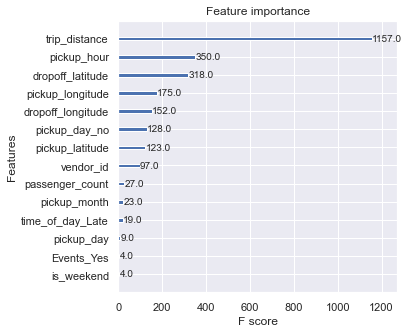

In [386]:
# xgb.plot_importance(best_xgb2)
# plt.rcParams['figure.figsize'] = [5, 5]
# plt.show()

# What went wrong? <a class="anchor" id="wrong"></a>

Best model is the default one - need more hyperparameters

In [418]:
best_model = xgb.XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.09, objective='reg:squaredlogerror', \
                              eval_metric='rmsle', verbosity=0, early_stopping_rounds=30, \
                              random_state=42).fit(X_train, y_train)
y_pred_train_best, y_pred_val_best, best_scores = eval_scores(best_model, X_train, X_val, y_train, y_val)

####################################
          TRAINING SCORES
####################################
R2 Score: 0.0042
RMSE Score: 5734.1397
RMSLE Score: 0.5085

####################################
        VALIDATION SCORES
####################################
R2 Score: 0.0131
RMSE Score: 3243.8794
RMSLE Score: 0.5110


In [422]:
best_model = xgb.XGBRegressor(n_estimators=500, max_depth=8, learning_rate=0.09, objective='reg:squaredlogerror', \
                              eval_metric='rmsle', verbosity=0, early_stopping_rounds=30, \
                              random_state=42).fit(X_train, y_train)
y_pred_train_best, y_pred_val_best, best_scores = eval_scores(best_model, X_train, X_val, y_train, y_val)

####################################
          TRAINING SCORES
####################################
R2 Score: 0.0043
RMSE Score: 5734.0096
RMSLE Score: 0.5072

####################################
        VALIDATION SCORES
####################################
R2 Score: 0.0133
RMSE Score: 3243.5936
RMSLE Score: 0.5097


In [423]:
best_model = xgb.XGBRegressor(n_estimators=2000, max_depth=8, learning_rate=0.09, objective='reg:squaredlogerror', \
                              eval_metric='rmsle', verbosity=0, early_stopping_rounds=30, \
                              random_state=42).fit(X_train, y_train)
y_pred_train_best, y_pred_val_best, best_scores = eval_scores(best_model, X_train, X_val, y_train, y_val)

####################################
          TRAINING SCORES
####################################
R2 Score: 0.0060
RMSE Score: 5729.1425
RMSLE Score: 0.4788

####################################
        VALIDATION SCORES
####################################
R2 Score: 0.0181
RMSE Score: 3235.6582
RMSLE Score: 0.4834


# Final Model <a class="anchor" id="final"></a>

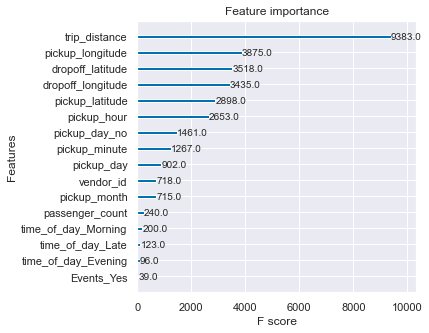

In [439]:
xgb.plot_importance(best_model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [425]:
# train on all data
best_model.fit(X_dum, y)
y_preds = best_model.predict(X_test)

In [449]:
pd.Series(y_preds)

0          850.799744
1         1025.491699
2          441.966614
3         1020.205627
4          275.566589
             ...     
625129     243.789322
625130     881.249634
625131    1155.738525
625132    1085.122437
625133     928.932861
Length: 625134, dtype: float32

In [447]:
pd.Series(y_preds).to_csv('y_preds.csv', index = False, header=False)

#### Improvements for the future
- learn more efficient ways to do hyperparameter tuning
- try removing outliers to see if they affect RMSLE performance